The original dataset of paper: "Hate Speech Dataset from a White Supremacy Forum" (https://www.aclweb.org/anthology/W18-5102/)
which can be accessed from: https://github.com/Vicomtech/hate-speech-dataset
was preprocced, and I am using it here.

##  NLP binary classification
- dataset: Stromfront. It containes texts in two categories of Hate and Non-Hate. 
- goal: building hate-speach detection models that can be used on formal documents in english language.
- previos preprocessing: dataset was preprocessed partially. Some non-English words detected. I used "langdetect" library to remove non-English sentences.

In [6]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

%matplotlib inline

In [19]:
# loading the dataset
data = pd.read_csv('Data/stormfront_hate_dataset_clean.csv')
# dataset does not have null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9780 entries, 0 to 9779
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9780 non-null   object
 1   label   9780 non-null   int64 
 2   split   9780 non-null   object
dtypes: int64(1), object(2)
memory usage: 229.3+ KB


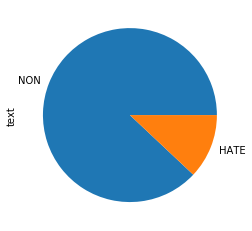

In [9]:
# dataset is unbalaced. label is binary: 1 indicates hate and 0 indicates non-hate
data.groupby(['label']).count()['text'].plot(kind='pie', labels=['NON','HATE'])
plt.savefig('Data/label distribution', dpi=300)
plt.show()

In [5]:
# number of records in each label
data.groupby(['label']).count()['text']

label
0    8605
1    1175
Name: text, dtype: int64

In [21]:
#expanding the display width
pd.set_option('display.max_colwidth', -1)
clear_output()

# printing the last records
data.tail()

,text,label,split
9775,It is good to keep track of the enemy as well and see what they are saying .,0,test
9776,Charlton Heston is rolling over in his grave knowing an ape has been elected to the white house .,1,test
9777,Happy Thanksgiving everyone .,0,test
9778,I'm reporting here that I have n't seen or heard anything on talk radio or TV that even hints at Jewish supremacist ethnic cleansing of Whites from USA or Europe .,0,test
9779,Never mind the mess on the floor brother .,0,test


In [22]:
# extracting two features (polarity and subjectivity) from texts
data['polarity'] = data['text'].apply(lambda x: TextBlob(x).polarity)
data['subjectivity'] = data['text'].apply(lambda x: TextBlob(x).subjectivity)
data.tail()

,text,label,split,polarity,subjectivity
9775,It is good to keep track of the enemy as well and see what they are saying .,0,test,0.700,0.600
9776,Charlton Heston is rolling over in his grave knowing an ape has been elected to the white house .,1,test,0.000,0.000
9777,Happy Thanksgiving everyone .,0,test,0.800,1.000
9778,I'm reporting here that I have n't seen or heard anything on talk radio or TV that even hints at Jewish supremacist ethnic cleansing of Whites from USA or Europe .,0,test,0.000,0.000
9779,Never mind the mess on the floor brother .,0,test,-0.175,0.175


In [23]:
# assesing the min, max, and mean of recently added features in the dataset
data.groupby(['label']).agg({'polarity': [min,max,np.mean,np.median], 'subjectivity':[min,max,np.mean, np.median]})

polarity                       subjectivity                      
           min  max      mean median          min  max      mean median
label                                                                  
0     -1.0      1.0  0.074363  0.0    0.0          1.0  0.322764  0.300
1     -1.0      1.0 -0.001099  0.0    0.0          1.0  0.370362  0.375

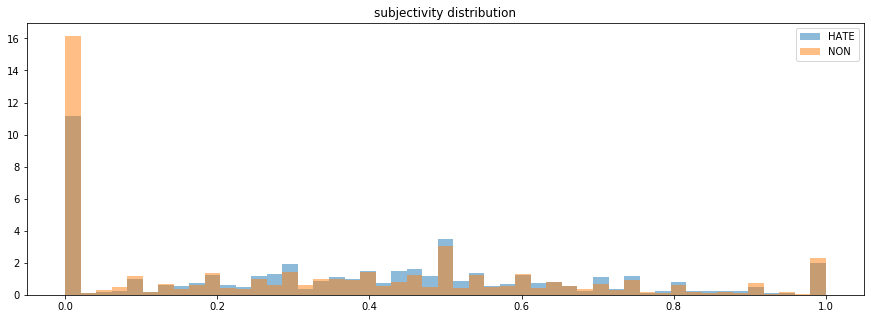

In [26]:
# exploring the distribution of the subjectivity in each category
plt.figure(figsize=(15,5))
bins = np.linspace(0,1,50)
plt.hist(data[data['label']==1]['subjectivity'], bins, alpha=.5, normed=True, label='HATE')
plt.hist(data[data['label']==0]['subjectivity'], bins, alpha=.5, normed=True, label='NON')
plt.legend(loc='upper right')
plt.title('subjectivity distribution')
plt.savefig('Data/subjectivity distribution', dpi=300)
clear_output()
plt.show()

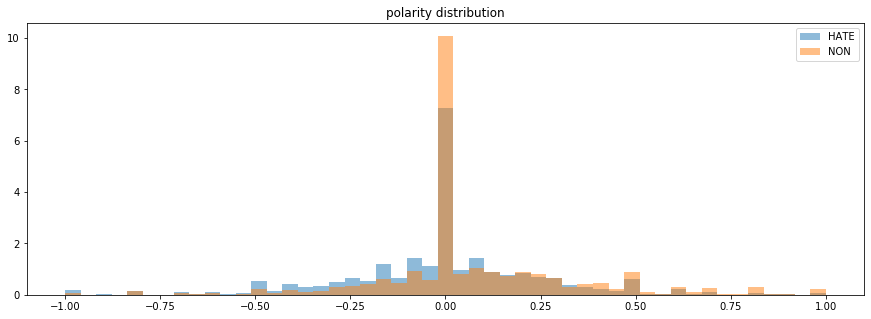

In [25]:
# exploring the distribution of the polarity in each category
plt.figure(figsize=(15,5))
bins = np.linspace(-1,1,50)
plt.hist(data[data['label']==1]['polarity'], bins, alpha=.5, normed=True, label='HATE')
plt.hist(data[data['label']==0]['polarity'], bins, alpha=.5, normed=True, label='NON')
plt.legend(loc='upper right')
plt.title('polarity distribution')
plt.savefig('Data/polarity distribution', dpi=300)
clear_output()
plt.show()

In [29]:
# since both new features have equal distribution in Hate and Non_Hate categories, I concluded that they are not valuable features.
# So, I save the result, but remove them in the following process.
data.to_csv('Data/cleaned_stormfront_with_polarity_and_subjectivity.csv', float_format='%.5f', index=False)

In [30]:
data = data.drop(columns=['polarity','subjectivity'])
data.head(3)

,text,label,split
0,"I love them to death and would kill anyone that threatened them , but they will be hell when they get older ...",0,train
1,She could just move to the Christian part of Nigeria where there is no Sharia law .,0,train
2,Some graduate programs will cater to working professionals and will do the bulk of the classes on line with only one or two days per month actually on campus .,0,train


In [27]:
# exploring the portions of train and test
data.groupby(['split','label'])['text'].count()

split  label
test   0        1721
       1        235 
train  0        6884
       1        940 
Name: text, dtype: int64

In [28]:
# both train and test sets have about 88% of Non-Hate lables
1721/(1721+235), 6884/(6884+940)

(0.8798568507157464, 0.8798568507157464)

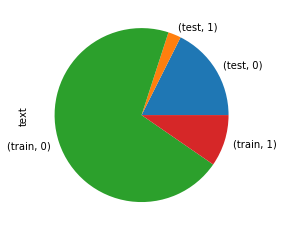

In [20]:
# portions of testing and training sets 
data.groupby(['split','label']).count()['text'].plot(kind='pie')
plt.show()

## feature extraction

In [31]:
import nltk
import string
import re

In [39]:
# Cleaning and tokenizing the texts. Dataset was partially cleaned. Yet, some non-english words or symbols showed up in tokens.
# Therefore, I decided to update tokenization process with more resitricted rules.

def tokenize_text(text):
    '''
    input: a string (sentence)
    output: an array of strings (words)
    '''
    # nltk stopwords in english
    stopwords = nltk.corpus.stopwords.words('english')
    # all english words in nltk corpus
    eng_words = [w.lower() for w in nltk.corpus.words.words('en')]
    ps_stemmer = nltk.PorterStemmer()
    
    # removing punctuation and convert all leters to lowercase
    text = ''.join([letter.lower() for letter in text if letter not in string.punctuation])
    words = re.split('\W', text)
    # removing all non-english words
    words = [word for word in words if word in eng_words]
    # removing english stop words
    words = [ps_stemmer.stem(word) for word in words if word not in stopwords]
    
    return(words)

In [40]:
# testing the tokenize_text function
for i in range(10):
    tokenz = tokenize_text(data['text'][i])
    print(i, tokenz)

0 ['love', 'death', 'would', 'kill', 'anyon', 'hell', 'get', 'older']
1 ['could', 'move', 'christian', 'part', 'sharia', 'law']
2 ['graduat', 'cater', 'work', 'bulk', 'class', 'line', 'one', 'two', 'day', 'per', 'month', 'actual', 'campu']
3 ['total', 'shi']
4 ['even', 'rest', 'world', 'dagger', 'readi', 'strike', 'heart', 'still', 'show', 'kind']
5 ['nice', 'also']
6 ['wisdom', 'come', 'man', 'anoth', 'man', 'anu', 'well', 'made', 'use', 'vagina']
7 ['thank']
8 ['check', 'around', 'see', 'area', 'within', 'desir', 'field', 'studi']
9 ['bloodi', 'object', 'ignor', 'facil', 'one', 'thread', 'pray', 'want', 'god', 'wont', 'count', 'em']


In [41]:
# the above is the result of the following sentences
data['text'][:10]

0    I love them to death and would kill anyone that threatened them , but they will be hell when they get older ...                                                
1    She could just move to the Christian part of Nigeria where there is no Sharia law .                                                                            
2    Some graduate programs will cater to working professionals and will do the bulk of the classes on line with only one or two days per month actually on campus .
3    The total was $ 0.75 shy of $ 400 .                                                                                                                            
4    Even when the rest of the world has daggers ready to strike at your heart , you still show them kindness ..                                                    
5    And nice website also                                                                                                                                          
6    And t

In [42]:
# uploading the TF-IDF method to vectorize the texts
from sklearn.feature_extraction.text import TfidfVectorizer
import time

In [46]:
tfidf_vect = TfidfVectorizer(analyzer=tokenize_text) # passing the tokenization function to TF-IDF

# creating the sparse matrix of texts using TF-IDF
start_t = time.time()
X_tfidf = tfidf_vect.fit_transform(data['text'])
end_t = time.time()
print('It took {} seconds to vectorize!'.format(round(end_t - start_t)))

# converting the sparse matrix to a dataframe
X_features = pd.DataFrame(X_tfidf.toarray())
# updating column names with the corresponding features 
X_features.columns = tfidf_vect.get_feature_names()

X_features.tail()

It took 3589 seconds to vectorize!


,ab,abandon,abduct,abhor,abid,abil,abl,aboard,abomin,abort,...,zealot,zero,zimbabw,zionism,zionist,zip,zombi,zone,zoo,zulu
9775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
# First, I stored the extracted features. but the size was too large(467 MB). 
#So, I decided to store the sparse matrix and column-names instead.

#X_features.to_csv('Data/X_features_stormfront.csv', float_format='%.5f', index=False)

In [51]:
type(X_tfidf), type(tfidf_vect.get_feature_names())

(scipy.sparse.csr.csr_matrix, list)

In [64]:
# storing column names
pd.DataFrame(columns=tfidf_vect.get_feature_names()).to_csv('Data/features_column_names.csv')
# or storing it as a text file
#np.savetxt('Data/column_names.txt', tfidf_vect.get_feature_names(), delimiter=',', fmt='%s')

In [66]:
# storing the sparse matrix
import scipy.sparse as ss

ss.save_npz('Data/features_sparse_matrix.npz', X_tfidf)

## feature selection

In [117]:
# uploading the feature selection function and method
from sklearn.feature_selection import SelectKBest, chi2

In [118]:
X = X_features.copy()
# creating a serie of labels (target)
y = data['label']

In [119]:
# selecting 3000 of best features with chi-sqaure

skb = SelectKBest(chi2, k=3000)
skb.fit_transform(X, y)

selected_col = [X.columns[i] for i in skb.get_support(indices=True)]
X = X[selected_col]
X.shape

(9780, 3000)

In [120]:
# selected features
X.head()

,abid,abil,abl,aboard,abomin,abort,absolut,absorb,absurd,abus,...,youv,yucki,z,zero,zimbabw,zionism,zionist,zombi,zoo,zulu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training models
I am using the whole dataset (train and test splits) for training and testing. I will use another dataset for validation in the future. I am use 10-fold cross-validation to build models. Since the dataset is not balanced, accuacy score can not be trusted to evaluate the result.

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support as scores
from sklearn.metrics import confusion_matrix

### 1. Random Forest

In [127]:
def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    k_fold = KFold(n_splits=10)
    y_pred = cross_val_predict(rf, X, y, cv=k_fold)
    
    print('~~~ number of trees: {} , depth: {} ~~~'.format(n_est, depth))
    print('Confusion Matrix:\n', confusion_matrix(y, y_pred))
    
    precision, recall, fscore, support = scores(y, y_pred, pos_label=1, average='binary')
    accuracy = np.mean(y == y_pred)
    fscore = 2*recall*precision/(recall+precision)
    
    print('Precision: {} \t Recall: {} \t Accuracy: {} \t F-Score: {}\n'.format(
        round(precision,4), round(recall,4), round(accuracy,4), round(fscore,4)))

In [128]:
# building random forest models with different values for hyper parameters
for n_est in [100, 150, 300]:
    for depth in [30, 60, 90, None]:
        train_RF(n_est, depth)

~~~ number of trees: 100 , depth: 30 ~~~
Confusion Matrix:
 [[8605    0]
 [1174    1]]
Precision: 1.0 	 Recall: 0.0009 	 Accuracy: 0.88 	 F-Score: 0.0017

~~~ number of trees: 100 , depth: 60 ~~~
Confusion Matrix:
 [[8594   11]
 [1138   37]]
Precision: 0.7708 	 Recall: 0.0315 	 Accuracy: 0.8825 	 F-Score: 0.0605

~~~ number of trees: 100 , depth: 90 ~~~
Confusion Matrix:
 [[8583   22]
 [1113   62]]
Precision: 0.7381 	 Recall: 0.0528 	 Accuracy: 0.8839 	 F-Score: 0.0985

~~~ number of trees: 100 , depth: None ~~~
Confusion Matrix:
 [[8515   90]
 [1069  106]]
Precision: 0.5408 	 Recall: 0.0902 	 Accuracy: 0.8815 	 F-Score: 0.1546

~~~ number of trees: 150 , depth: 30 ~~~
Confusion Matrix:
 [[8605    0]
 [1171    4]]
Precision: 1.0 	 Recall: 0.0034 	 Accuracy: 0.8803 	 F-Score: 0.0068

~~~ number of trees: 150 , depth: 60 ~~~
Confusion Matrix:
 [[8592   13]
 [1137   38]]
Precision: 0.7451 	 Recall: 0.0323 	 Accuracy: 0.8824 	 F-Score: 0.062

~~~ number of trees: 150 , depth: 90 ~~~
Confus

### 2. Gradient Boosting

In [132]:
from sklearn.ensemble import GradientBoostingClassifier

In [133]:
def train_GB(est, depth, lr=.1):
    gb = GradientBoostingClassifier(n_estimators=est, max_depth=depth, learning_rate=lr)
    k_fold = KFold(n_splits=10)
    y_pred = cross_val_predict(gb, X, y, cv=k_fold)
    
    print('~~~ number of trees: {} , depth: {} ~~~'.format(est, depth))
    print('Confusion Matrix:\n', confusion_matrix(y, y_pred))
    
    precision, recall, fscore, support = scores(y, y_pred, pos_label=1, average='binary')
    accuracy = np.mean(y == y_pred)
    fscore = 2*recall*precision/(recall+precision)
    
    print('Precision: {} \t Recall: {} \t Accuracy: {} \t F-Score: {}\n'.format(
        round(precision,4), round(recall,4), round(accuracy,4), round(fscore,4)))

In [135]:
train_GB(150, 7)

~~~ number of trees: 300 , depth: 7 ~~~
Confusion Matrix:
 [[8487  118]
 [1001  174]]
Precision: 0.5959 	 Recall: 0.1481 	 Accuracy: 0.8856 	 F-Score: 0.2372



### 3. Suport Vector Machine (SVM)

In [136]:
from sklearn.svm import SVC

In [139]:
def train_svm(c=1.0, k='linear', gm='auto'):
    svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    k_fold = KFold(n_splits=10)
    y_pred = cross_val_predict(svm, X, y, cv=k_fold)
    
    print('~~~ C: {} , kernel: {} , gamma: {} ~~~'.format(c, k, gm))
    print('Confusion Matrix:\n', confusion_matrix(y, y_pred))
    
    precision, recall, fscore, support = scores(y, y_pred, pos_label=1, average='binary')
    accuracy = np.mean(y == y_pred)
    fscore = 2*recall*precision/(recall+precision)
    
    print('Precision: {} \t Recall: {} \t Accuracy: {} \t F-Score: {}\n'.format(
        round(precision,4), round(recall,4), round(accuracy,4), round(fscore,4)))

In [140]:
train_svm()

~~~ C: 1.0 , kernel: linear , gamma: auto ~~~
Confusion Matrix:
 [[8580   25]
 [1093   82]]
Precision: 0.7664 	 Recall: 0.0698 	 Accuracy: 0.8857 	 F-Score: 0.1279



### 4. Multonomial Naive Bayes

In [141]:
from sklearn.naive_bayes import MultinomialNB

In [142]:
def train_mnb():
    mnb = MultinomialNB()
    k_fold = KFold(n_splits=10)
    y_pred = cross_val_predict(mnb, X, y, cv=k_fold)
    
    print('Navie Bayes result:')
    print('Confusion Matrix:\n', confusion_matrix(y, y_pred))
    
    precision, recall, fscore, support = scores(y, y_pred, pos_label=1, average='binary')
    accuracy = np.mean(y == y_pred)
    fscore = 2*recall*precision/(recall+precision)
    
    print('Precision: {} \t Recall: {} \t Accuracy: {} \t F-Score: {}\n'.format(
        round(precision,4), round(recall,4), round(accuracy,4), round(fscore,4)))

In [143]:
train_mnb()

Navie Bayes result:
Confusion Matrix:
 [[8602    3]
 [1158   17]]
Precision: 0.85 	 Recall: 0.0145 	 Accuracy: 0.8813 	 F-Score: 0.0285



## Improvement plan:
I will: 
- evaluate the lenght of sentences (number of words) after cleaning the texts. Some texts may shortened too much that just make noise and may need to be removed from dataset
- try n-grams for n=1,2,3 for tokenization step
- tuning all models by changing the hyperparameters values